In [1]:
name="AuAuGrad"

In [2]:
import os
import numpy as np
#import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

from multiprocessing import Pool
from multiprocessing import cpu_count

import time

### Setup working folders


In [3]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [4]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [5]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [6]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")
design_Au = pd.read_csv(filepath_or_buffer="DataFiles/AuAu200_design")
design_validation = pd.read_csv(filepath_or_buffer="DataFiles/AuAu200_validation_design")

In [7]:
#Simulation outputs at the design points
simulation_df = []
simulation_df_Au = []
for idf in range(0,4):
    simulation_df_Au.append(pd.read_csv(filepath_or_buffer=f"DataFiles/AuAu200_simulation_{idf}"))
    simulation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_{idf}"))
    simulation_df[idf]=simulation_df[idf][simulation_df_Au[0].keys()]

    #simulation_sd_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_error_{idf}"))

In [8]:
design_Au.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,6.90877,-0.06769,0.98153,0.92763,2.61235,1.34389,0.00988,0.21946,-0.28087,0.49299,0.10715,0.14627,0.19076,0.09729,0.15270,4.79271,0.14759
1,5.71985,0.12337,1.34278,1.10651,2.17324,0.90060,0.05149,0.23432,-0.37329,0.29940,0.08497,0.12393,0.20455,0.07722,0.29229,5.81536,0.14498
2,6.92087,0.13791,1.06155,1.15276,2.77641,1.03337,0.00518,0.23255,-0.35375,0.79445,0.13705,0.11665,0.18175,0.07408,0.07515,3.39156,0.15274
3,6.23697,0.11147,0.82684,1.01294,2.40816,1.13235,-0.08793,0.20885,-1.19838,0.43428,0.12346,0.07759,0.17377,0.06128,0.11686,4.61781,0.14550
4,7.06824,0.32229,1.38858,0.84729,1.23917,1.12739,-0.07829,0.23634,-0.22399,0.27735,0.14276,0.11019,0.20315,0.07877,-0.10924,6.42583,0.13879


In [9]:
design.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,15.81754,-0.06769,0.98153,0.92763,2.61235,1.34389,0.00988,0.21946,-0.28087,0.49299,0.10715,0.14627,0.19076,0.09729,0.15270,4.79271,0.14759
1,13.43970,0.12337,1.34278,1.10651,2.17324,0.90060,0.05149,0.23432,-0.37329,0.29940,0.08497,0.12393,0.20455,0.07722,0.29229,5.81536,0.14498
2,15.84174,0.13791,1.06155,1.15276,2.77641,1.03337,0.00518,0.23255,-0.35375,0.79445,0.13705,0.11665,0.18175,0.07408,0.07515,3.39156,0.15274
3,14.47395,0.11147,0.82684,1.01294,2.40816,1.13235,-0.08793,0.20885,-1.19838,0.43428,0.12346,0.07759,0.17377,0.06128,0.11686,4.61781,0.14550
4,16.13648,0.32229,1.38858,0.84729,1.23917,1.12739,-0.07829,0.23634,-0.22399,0.27735,0.14276,0.11019,0.20315,0.07877,-0.10924,6.42583,0.13879


In [10]:
design_validation.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,7.30696,-0.61335,1.17739,0.98622,1.24173,1.34216,0.11881,0.22059,-0.68223,0.24863,0.11678,0.10846,0.14633,0.09276,0.16548,4.48798,0.15136
1,4.80624,-0.30146,0.87235,1.11825,1.29157,1.68622,0.01821,0.18231,-0.99405,0.95749,0.17885,0.13953,0.17479,0.10002,-0.23630,4.55209,0.15316
2,6.34638,0.50810,0.85910,0.61338,1.14017,1.03135,-0.09393,0.21714,-1.07597,0.63656,0.10159,0.10165,0.24848,0.08054,0.12548,6.08133,0.15473
3,5.70620,-0.53809,1.73927,0.81786,2.32981,1.82643,-0.05917,0.18393,0.16338,1.01427,0.14438,0.12449,0.16211,0.10141,0.28260,5.04272,0.15018
4,6.85955,0.05154,0.48697,0.95485,1.44232,1.23290,0.08224,0.26589,-0.18979,0.85671,0.08464,0.11702,0.23338,0.07929,0.36065,4.58853,0.14579


In [11]:
simulation_df_Au_validation=pd.read_csv(filepath_or_buffer=f"DataFiles/AuAU200_validation_0")


In [12]:
simulation_df_Au_validation.shape

(93, 36)

In [13]:
X = design.values
XAu = design_Au.values
Xv = design_validation.values

In [14]:
X.shape

(473, 17)

In [15]:
XAu.shape

(473, 17)

In [16]:
Xv.shape

(93, 17)

In [17]:
df_clms=simulation_df[0].keys()

In [18]:
simulation_df_Au_validation.shape

(93, 36)

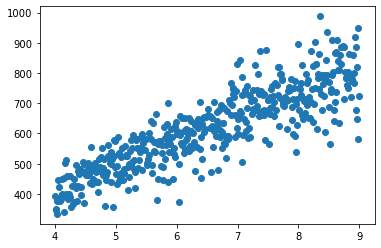

In [19]:
plt.scatter(XAu[:,0],simulation_df_Au[0].values[:,0])

In [20]:
#Introduce a random permutation split to ensure randomness of training and testing data sets
all_index = np.arange(0,XAu.shape[0])
sfl_index = np.random.permutation(all_index)

### Normalize all the other models using mean and variance of observable in the PbPb 2.76 TeV Grad model

We perform this normalization to avoid data leakages and to provide a robust normalization. 

In [21]:
#normalize data with respect to lower fidelity
s_l = StandardScaler()
x = simulation_df[0].values
s_l.fit(x)
for idf in range(0,4):
    x_tmp = simulation_df[idf].values
    simulation_df[idf]= pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)
    
    x_tmp = simulation_df_Au[idf].values
    simulation_df_Au[idf]= pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)
    

#diff = np.array(prior_df.loc['max'].values - prior_df.loc['min'].values ).reshape(1,-1)
#diff_mat = np.repeat(diff,X.shape[0],axis=0)
#print(f'Shape of diff matt {diff_mat.shape}')
#X= np.divide(X,diff_mat)

In [22]:
print('normalizing validation data')
x_tmp = simulation_df_Au_validation.values
print(x_tmp)
simulation_df_Au_validation=pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)

normalizing validation data
[[6.79470390e+02 5.28721444e+02 3.77220283e+02 ... 2.32333907e-02
  2.47413895e-02 2.18087984e-02]
 [5.06610998e+02 3.89387330e+02 2.68567238e+02 ... 1.35370801e-02
  1.43197658e-02 1.12191806e-02]
 [6.01920037e+02 4.97966578e+02 3.85784684e+02 ... 2.22597765e-02
  2.31408449e-02 2.45965445e-02]
 ...
 [4.65105346e+02 3.78807597e+02 2.89015336e+02 ... 3.21312963e-02
  3.45667478e-02 3.86288825e-02]
 [7.83618121e+02 6.69338022e+02 5.19107230e+02 ... 1.65346961e-02
  1.72146242e-02 1.63043144e-02]
 [5.44399579e+02 4.26784811e+02 3.16365101e+02 ... 2.75511984e-02
  2.93476172e-02 2.38313993e-02]]


In [23]:
simulation_df_Au_validation.head()

,dN_dy_pion[0 5],dN_dy_pion[ 5 10],dN_dy_pion[10 20],dN_dy_pion[20 30],dN_dy_pion[30 40],dN_dy_pion[40 50],dN_dy_kaon[0 5],dN_dy_kaon[ 5 10],dN_dy_kaon[10 20],dN_dy_kaon[20 30],...,v22[10 20],v22[20 30],v22[30 40],v22[40 50],v32[0 5],v32[ 5 10],v32[10 20],v32[20 30],v32[30 40],v32[40 50]
0,-2.523938,-2.507397,-2.472066,-2.315738,-2.195433,-2.086820,-2.551722,-2.518510,-2.501256,-2.337592,...,0.423260,0.236187,0.022224,0.153342,-0.289278,0.046856,-0.152791,-0.512065,-0.435370,-0.663728
1,-3.196920,-3.136012,-3.078607,-2.887698,-2.749855,-2.632324,-3.225675,-3.169963,-3.111651,-2.916424,...,-0.332449,-0.272415,-0.584451,-0.597102,-1.296596,-1.528788,-1.336980,-1.631970,-1.491588,-1.636714
2,-2.825860,-2.646150,-2.424257,-2.174481,-1.893672,-1.592051,-2.822543,-2.648216,-2.410310,-2.167521,...,-0.824739,-0.887580,-0.767446,-0.918534,-0.837533,-0.908399,-0.696357,-0.624515,-0.597583,-0.407587
3,-3.165504,-3.141624,-3.007672,-2.948449,-2.777787,-2.665442,-3.192599,-3.173017,-3.033367,-2.972063,...,0.374814,0.645073,0.550757,0.292545,-0.123634,0.334304,-0.080955,-0.096546,-0.719297,-0.874527
4,-2.664786,-2.425918,-2.245354,-1.994942,-1.788240,-1.640354,-2.670460,-2.427583,-2.254011,-2.003044,...,-0.545203,-0.532886,-0.298640,-0.400885,-0.613893,-1.177382,-1.083634,-0.760832,-0.820880,-0.802603


In [24]:
simulation_df[0].head()

,dN_dy_pion[0 5],dN_dy_pion[ 5 10],dN_dy_pion[10 20],dN_dy_pion[20 30],dN_dy_pion[30 40],dN_dy_pion[40 50],dN_dy_kaon[0 5],dN_dy_kaon[ 5 10],dN_dy_kaon[10 20],dN_dy_kaon[20 30],...,v22[10 20],v22[20 30],v22[30 40],v22[40 50],v32[0 5],v32[ 5 10],v32[10 20],v32[20 30],v32[30 40],v32[40 50]
0,0.619257,0.530218,0.327470,0.272370,0.033842,-0.056312,0.614684,0.521940,0.333326,0.299804,...,0.615527,0.517000,0.657858,0.602001,-0.150874,0.321698,0.264980,0.319903,0.324693,0.463557
1,-0.180698,-0.092690,0.083062,0.245721,0.050315,0.133230,-0.200765,-0.094240,0.068796,0.233722,...,-0.621244,-0.382229,-0.340909,-0.443330,-0.150021,-0.367147,-0.030290,-0.272368,-0.140120,-0.342011
2,1.037999,1.022160,0.995952,0.931593,0.987230,0.988813,0.986484,1.001289,0.975533,0.906810,...,-0.768037,-0.625974,-0.694006,-0.733197,-0.561079,-0.897921,-0.666548,-0.737213,-0.796565,-0.605217
3,0.137978,0.101764,0.162907,0.297756,0.415575,0.474692,0.160239,0.119394,0.162974,0.302322,...,-0.487681,-0.416800,-0.429595,-0.465382,-0.782748,-0.794482,-0.852256,-0.773484,-0.507853,-0.498973
4,0.692222,0.839457,0.934473,0.870276,1.038612,1.065842,0.639250,0.758631,0.873731,0.801596,...,-0.545879,-0.513280,-0.489739,-0.425560,0.370203,0.074837,-0.009571,0.044080,-0.003329,0.008152


In [25]:
simulation_df_Au[0].head()

,dN_dy_pion[0 5],dN_dy_pion[ 5 10],dN_dy_pion[10 20],dN_dy_pion[20 30],dN_dy_pion[30 40],dN_dy_pion[40 50],dN_dy_kaon[0 5],dN_dy_kaon[ 5 10],dN_dy_kaon[10 20],dN_dy_kaon[20 30],...,v22[10 20],v22[20 30],v22[30 40],v22[40 50],v32[0 5],v32[ 5 10],v32[10 20],v32[20 30],v32[30 40],v32[40 50]
0,-2.466885,-2.340405,-2.210642,-2.104270,-1.973155,-1.861972,-2.490622,-2.376828,-2.227500,-2.117685,...,-0.315905,-0.197261,-0.022988,-0.190521,-0.671299,-0.749780,-0.650099,-0.583695,-0.545412,-0.612321
1,-2.933848,-2.754448,-2.628082,-2.468001,-2.315428,-2.197366,-2.967860,-2.790162,-2.680301,-2.518459,...,-0.816157,-0.921607,-0.915112,-1.089463,-0.962587,-0.990708,-1.223701,-1.014291,-1.188219,-1.217243
2,-2.325311,-2.236444,-2.154113,-1.995829,-1.872947,-1.757504,-2.370010,-2.284442,-2.189029,-2.030663,...,-1.072326,-1.129969,-1.213798,-1.305465,-1.393720,-1.364287,-1.488997,-1.364108,-1.397129,-1.374673
3,-2.667782,-2.576655,-2.447551,-2.262546,-2.102623,-1.978883,-2.699629,-2.607532,-2.490498,-2.296631,...,-0.954619,-1.035027,-0.906722,-1.007988,-1.443761,-1.425859,-1.578666,-1.373466,-1.307209,-1.347564
4,-2.331930,-2.154519,-1.957723,-1.757908,-1.531543,-1.370540,-2.380620,-2.220087,-2.015272,-1.805281,...,-1.028587,-0.882366,-1.016598,-0.971075,-0.726944,-0.616042,-0.817584,-0.878947,-0.625988,-0.632455


In [26]:
for idf in range(0,4):
    Y = simulation_df[idf].values
    print('###########################\n for PbPb 2760')
    print( "X.shape : "+ str(X.shape) )
    print( "Y.shape : "+ str(Y.shape) )

    print('###########################\n for AuAU 200')
    Y_Au = simulation_df_Au[idf].values
    print( "X.shape : "+ str(XAu.shape) )
    print( "Y.shape : "+ str(Y_Au.shape) )

###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for AuAU 200
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for AuAU 200
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for AuAU 200
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 36)
###########################
 for AuAU 200
X.shape : (473, 17)
Y.shape : (473, 36)


In [27]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [28]:
observables = ['dNch_deta',
 'dET_deta',
 'dN_dy_pion',
 'dN_dy_kaon',
 'dN_dy_proton',
 'mean_pT_pion',
 'mean_pT_kaon',
 'mean_pT_proton',
 'pT_fluct',
 'v22',
 'v32',
 'v42']

In [29]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [30]:
observables_latex = ['$dN_{ch} / d\\eta$',
 '$dE_T / d\\eta$',
 '${dN_{\\pi}} / {dy}$',
 '${dN_{K}} / {dy}$',
 '${dN_{P}} / {dy}$',
 '$\\langle p_{T, \\pi} \\rangle$',
 '$\\langle p_{T, K} \\rangle$',
 '$\\langle p_{T, P} \\rangle$',
 '${\\delta p_T} / {\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

### Observables considered in this analysis

In [31]:
simulation_df[0].keys()

Index(['dN_dy_pion[0 5]', 'dN_dy_pion[ 5 10]', 'dN_dy_pion[10 20]',
       'dN_dy_pion[20 30]', 'dN_dy_pion[30 40]', 'dN_dy_pion[40 50]',
       'dN_dy_kaon[0 5]', 'dN_dy_kaon[ 5 10]', 'dN_dy_kaon[10 20]',
       'dN_dy_kaon[20 30]', 'dN_dy_kaon[30 40]', 'dN_dy_kaon[40 50]',
       'mean_pT_pion[0 5]', 'mean_pT_pion[ 5 10]', 'mean_pT_pion[10 20]',
       'mean_pT_pion[20 30]', 'mean_pT_pion[30 40]', 'mean_pT_pion[40 50]',
       'mean_pT_kaon[0 5]', 'mean_pT_kaon[ 5 10]', 'mean_pT_kaon[10 20]',
       'mean_pT_kaon[20 30]', 'mean_pT_kaon[30 40]', 'mean_pT_kaon[40 50]',
       'v22[0 5]', 'v22[ 5 10]', 'v22[10 20]', 'v22[20 30]', 'v22[30 40]',
       'v22[40 50]', 'v32[0 5]', 'v32[ 5 10]', 'v32[10 20]', 'v32[20 30]',
       'v32[30 40]', 'v32[40 50]'],
      dtype='object')

In [32]:
observables_choosen = ['dN_dy_pion[0 5]',
 'dN_dy_pion[40 50]',
# 'dN_dy_kaon[0 5]',
# 'dN_dy_kaon[60 70]',
# 'dN_dy_proton[0 5]',
# 'dN_dy_proton[60 70]',
 'mean_pT_pion[0 5]',
 'mean_pT_pion[40 50]',
# 'mean_pT_kaon[0 5]',
# 'mean_pT_kaon[60 70]',               
# 'mean_pT_proton[0 5]',
# 'mean_pT_proton[60 70]',
 'v22[0 5]',
  'v22[40 50]']

###  Build the source emulators and find length scales and white noise that we can use in multifidelity code to fix hyper parameters.

In [33]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
#from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib

In [35]:
GP_dic={}
n_opt = 10
n_proc=10
for selected_observable in observables_choosen:
    Y_l=simulation_df[0][selected_observable].values.reshape(-1,1)
    Y_h=simulation_df_Au[0][selected_observable].values.reshape(-1,1)
    Y_v=simulation_df_Au_validation[selected_observable].values.reshape(-1,1)
    
    x_train_h, x_test_h, y_train_h, y_test_h = XAu[sfl_index,:], Xv, Y_h[sfl_index,:], Y_v
    x_train_l, y_train_l = X[sfl_index,:], Y_l[sfl_index,:]
    print(selected_observable)
    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    low_gp_model = GPy.models.GPRegression(x_train_l,y_train_l, kernel)
        #high_gp_model.Gaussian_noise.fix(0)

        ## Fit the GP model
    
    low_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    print(low_gp_model)
    GP_dic[selected_observable]=low_gp_model

dN_dy_pion[0 5]
Optimization restart 1/10, f = -80.33081955287452
Optimization restart 2/10, f = -80.33027685561157
Optimization restart 3/10, f = -80.3300505742715
Optimization restart 4/10, f = -80.33076719568263
Optimization restart 5/10, f = 10.777364721079891
Optimization restart 6/10, f = -80.33081474975864
Optimization restart 7/10, f = 10.777364914668198
Optimization restart 8/10, f = -80.33047770314431
Optimization restart 9/10, f = -80.33073687650554
Optimization restart 10/10, f = -80.33033280330949

Name : GP regression
Objective : -80.33081955287452
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    4.0787578312310035  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.007269114334238062  |      +ve      |        
dN_dy_pion[40 50]
Optimizat

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -145.7852657081931
Optimization restart 2/10, f = -145.41984814244356
Optimization restart 3/10, f = -145.9431491298801
Optimization restart 4/10, f = -145.23907005085132
Optimization restart 5/10, f = -122.0586419996838
Optimization restart 6/10, f = -145.58858265332307
Optimization restart 7/10, f = -121.6249606117297
Optimization restart 8/10, f = -121.43441834657688
Optimization restart 9/10, f = -145.80032948559912
Optimization restart 10/10, f = -145.64282699296345

Name : GP regression
Objective : -145.9431491298801
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     8.414133059222129  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.002667125103393912  |      +ve      |        
mean_pT_pion[40 50]
Optimization res

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -77.87838460684591
Optimization restart 2/10, f = -77.88122196056653
Optimization restart 3/10, f = -77.88125546498458
Optimization restart 4/10, f = -36.671844546437455
Optimization restart 5/10, f = -77.88104930351227
Optimization restart 6/10, f = 650.0116111448449
Optimization restart 7/10, f = -77.88055512657138
Optimization restart 8/10, f = -77.88126803762998
Optimization restart 9/10, f = -77.88076012654159
Optimization restart 10/10, f = -77.88127444586632

Name : GP regression
Objective : -77.88127444586632
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    1.6103779407352943  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.007119152564774951  |      +ve      |        


### Transfer Learning using Emukit

In [34]:
def run_train_and_validation(x_train_s, x_train_t, x_test_t, y_train_s, y_train_t, y_test_t, obs_name):
    print('########################')
    print(obs_name)
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_s, x_train_t], [y_train_s, y_train_t])
    n_opt = 10
    n_proc = 10
    
    ## Construct a linear multi-fidelity model

    #kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    lin_tl_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_tl_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_tl_kernel, n_fidelities=2)
    
    #Set the parameters in the Source Gaussian Process
    
    rbf_l_scales = GP_dic[obs_name].rbf.lengthscale.values
    rbf_var = GP_dic[obs_name].rbf.variance.values[0]
    wn = GP_dic[obs_name].Gaussian_noise.variance.values[0]
    
    gpy_lin_tl_model.multifidelity.rbf.lengthscale.fix(value=rbf_l_scales)
    gpy_lin_tl_model.multifidelity.rbf.variance.fix(value=rbf_var)
    gpy_lin_tl_model.mixed_noise.Gaussian_noise.fix(wn)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_tl_model = GPyMultiOutputWrapper(gpy_lin_tl_model, 2, n_optimization_restarts=n_opt,
                                         parallel=True, num_processes=n_proc)

    ## Fit the model
    st_l = time.time()
    lin_tl_model.optimize()
    et_l = time.time()
    
    #print("parameter array provided")
    #print(f'{rbf_l_scales} noise {wn}')
    
    if np.allclose(lin_tl_model.gpy_model.multifidelity.rbf.lengthscale.values, rbf_l_scales):
          print('RBF lengthscales are the same for low fidelity after optimization')
    if wn == lin_tl_model.gpy_model.mixed_noise.Gaussian_noise.variance.values[0]:
          print('White noise are the same after optimization')
    print('parameter array of multifidelity linear')
    print(lin_tl_model.gpy_model.param_array)
    print(f'time for linear mf optimization {et_l-st_l}')
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    sd_gp_model = GPy.models.GPRegression(x_train_t,y_train_t, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    sd_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    
    x_temp = convert_x_list_to_array([x_test_t,x_test_t])
    x_test_t_idf_index = x_temp[x_test_t.shape[0]:,:]
    x_test_s_idf_index = x_temp[0:x_test_t.shape[0],:]
    
    
    #Transfer learning predictions and validation score calculations
    t_mean_lin_tl_model, t_var_lin_tl_model = lin_tl_model.predict(x_test_t_idf_index)
    s_mean_lin_tl_model, s_var_lin_tl_model = lin_tl_model.predict(x_test_s_idf_index)


    print(t_mean_lin_tl_model.shape)
    r2_tl = r2_score(y_test_t,t_mean_lin_tl_model )
    mse_tl = mean_squared_error(y_test_t,t_mean_lin_tl_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_t,t_mean_lin_tl_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_t,t_mean_lin_tl_model )}')

    
    # Standard GP predicitons an validation score calculation
    t_mean_sd_gp_model, t_var_sd_gp_model  = sd_gp_model.predict(x_test_t)
    print(t_mean_sd_gp_model.shape)
    r2_sdgp = r2_score(y_test_t,t_mean_sd_gp_model)
    mse_sdgp = mean_squared_error(y_test_t,t_mean_sd_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_t,t_mean_sd_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_t,t_mean_sd_gp_model )}')
    

    lin_tl_normalized_residue = np.divide(np.array(t_mean_lin_tl_model-y_test_t).reshape(-1,1),np.sqrt(t_var_lin_tl_model.reshape(-1,1)))
   # nonlin_mf_normalize = np.divide(np.array(hf_mean_nonlin_mf_model-y_test_h).reshape(-1,1),np.sqrt(hf_var_nonlin_mf_model.reshape(-1,1))) 
    standard_gp_normalized_residue = np.divide(np.array(t_mean_sd_gp_model-y_test_t).reshape(-1,1),np.sqrt(t_var_sd_gp_model.reshape(-1,1))) 

    
    df_1 = pd.DataFrame.from_dict({'residue': lin_tl_normalized_residue.flatten(), 'name':'TL', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df_2 = pd.DataFrame.from_dict({'residue': standard_gp_normalized_residue.flatten(), 'name':'GP', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df = pd.concat(axis=0, ignore_index=True, objs=[df_1, df_2])
    #print(f'Residual Data shape {df.shape}')
    #sns.histplot(df, x="residue", hue="name", element="step", fill = True, common_norm=False, ax=ax22, legend=True)
    #ax22.legend()
    #ax22.set_title(f'Validation Residuals for {obs_name} with {x_train_h.shape[0]} training samples')
    #plt.tight_layout()
    
    r2s= [r2_tl, r2_sdgp]
    mses=[mse_tl, mse_sdgp]
    Wn = [lin_tl_model.gpy_model.param_array[-2],lin_tl_model.gpy_model.param_array[-1], sd_gp_model.param_array[-1]]
    rho = lin_tl_model.gpy_model.param_array[-3]
    return np.hstack((r2s, mses, Wn, rho)), df

Uncomment the following block if you want to run and calculate residues.



In [35]:
# residue_df = pd.DataFrame()
# n_batch = 10
# df_results = pd.DataFrame(columns=["observable", "fold","n_training","r2_lin_tl","r2_stand_GP",
#                                   "mse_lin_tl","mse_stand_GP","wn_lin_tl","wn_stand_GP","rho"])
# split_i = 0


# for selected_observable in observables_choosen:
#     start_time = time.time()
#     Y_s=simulation_df[0][selected_observable].values.reshape(-1,1)
#     Y_t=simulation_df_Au[0][selected_observable].values.reshape(-1,1)
#     Y_v=simulation_df_Au_validation[selected_observable].values.reshape(-1,1)
#     x_train_t, x_test_t, y_train_t, y_test_t = XAu[sfl_index,:], Xv, Y_t[sfl_index,:], Y_v
#     x_train_s, y_train_s = X[sfl_index,:], Y_s[sfl_index,:]
    
#     for i in range(0,n_batch):
#         #
#         if i in [0,1,2,3,4,5,6,7,8,9]:
#             l=0
#             h=(x_train_t.shape[0]//n_batch)*(i+1)
#         else:
#             continue
#         if i == n_batch-1:
#             h=x_train_t.shape[0]
#         r2_mse_wn_rho, df_tmp = run_train_and_validation(x_train_s, x_train_t[l:h,:],x_test_t, y_train_s, y_train_t[l:h,:], y_test_t, selected_observable)
#         df_results = df_results.append({
#                 "observable": selected_observable,
#                 "fold": split_i,
#                 "n_training":h,
#                 "r2_lin_mf":r2_mse_wn_rho[0],
#                 "r2_stand_GP":r2_mse_wn_rho[1],
#                 "mse_lin_mf":r2_mse_wn_rho[2],
#                 "mse_stand_GP":r2_mse_wn_rho[3],
#                 "wn_lin_mf_0":r2_mse_wn_rho[4],
#                 "wn_lin_mf_1":r2_mse_wn_rho[5],
#                 "wn_stand_GP":r2_mse_wn_rho[6],
#                 "rho":r2_mse_wn_rho[7]}, ignore_index=True)
#         if residue_df.empty:
#             residue_df = df_tmp
#         else:
#             residue_df = pd.concat(axis=0, ignore_index=True, objs=[residue_df, df_tmp])
#     end_time =time.time()
#     print(f'Time it take for {selected_observable} is {end_time-start_time}')
#residue_df.to_csv(name+'_residue')
#df_results.to_csv(name)

In [41]:
if 'df_results' in globals():
    print('Pandas Dataframe exists\nDo not load from file')
else:
    print('Loading data from file')
    df_read = pd.read_csv(name,index_col=0)
    df_results = df_read

Pandas Dataframe exists
Do not load from file


In [42]:
df_results.head()

,observable,fold,n_training,r2_lin_tl,r2_stand_GP,mse_lin_tl,mse_stand_GP,wn_lin_tl,wn_stand_GP,rho,mse_lin_mf,r2_lin_mf,wn_lin_mf_0,wn_lin_mf_1
0,dN_dy_pion[0 5],0,47,NaN,0.781898,NaN,0.056306,NaN,0.001796,1.109381,0.019519,0.924393,0.007269,4.368581e-10
1,dN_dy_pion[0 5],0,94,NaN,0.931398,NaN,0.017711,NaN,0.001344,0.897814,0.013431,0.947976,0.007269,2.755636e-04
2,dN_dy_pion[0 5],0,141,NaN,0.953371,NaN,0.012038,NaN,0.003087,0.784739,0.008346,0.967671,0.007269,4.513433e-29
3,dN_dy_pion[0 5],0,188,NaN,0.956902,NaN,0.011126,NaN,0.003264,0.766279,0.008617,0.966624,0.007269,2.143126e-188
4,dN_dy_pion[0 5],0,235,NaN,0.959546,NaN,0.010444,NaN,0.003749,0.615187,0.007525,0.970853,0.007269,7.282431e-04


In [38]:
plot_x_training=df_results.n_training.unique()

def y_plot(feature):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[df_results['n_training']==nt][feature]))
    return np.array(y).flatten()

def y_plot_obs(feature, observable):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[(df_results['n_training']==nt) & (df_results['observable']==observable)][feature]))
    return np.array(y).flatten()



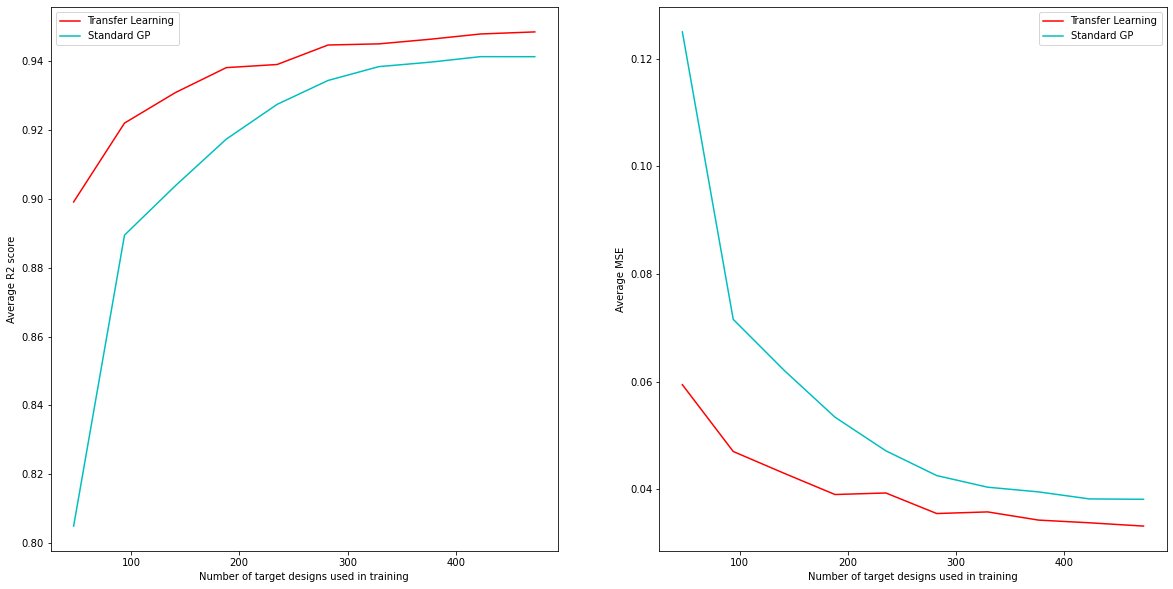

In [39]:
fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = ax

ax1.plot(plot_x_training,y_plot('r2_lin_mf'), c ='r', label='Transfer Learning')
ax1.plot(plot_x_training, y_plot('r2_stand_GP'), c ='c', label='Standard GP')
ax1.set_xlabel('Number of target designs used in training')
ax1.set_ylabel('Average R2 score')
ax1.legend()
    
ax2.plot(plot_x_training, y_plot('mse_lin_mf'), c ='r', label='Transfer Learning')
ax2.plot(plot_x_training, y_plot('mse_stand_GP'), c ='c', label='Standard GP')
ax2.set_xlabel('Number of target designs used in training')
ax2.set_ylabel('Average MSE')
ax2.legend()
#save_fig(f'{name}_ARD_PTB')

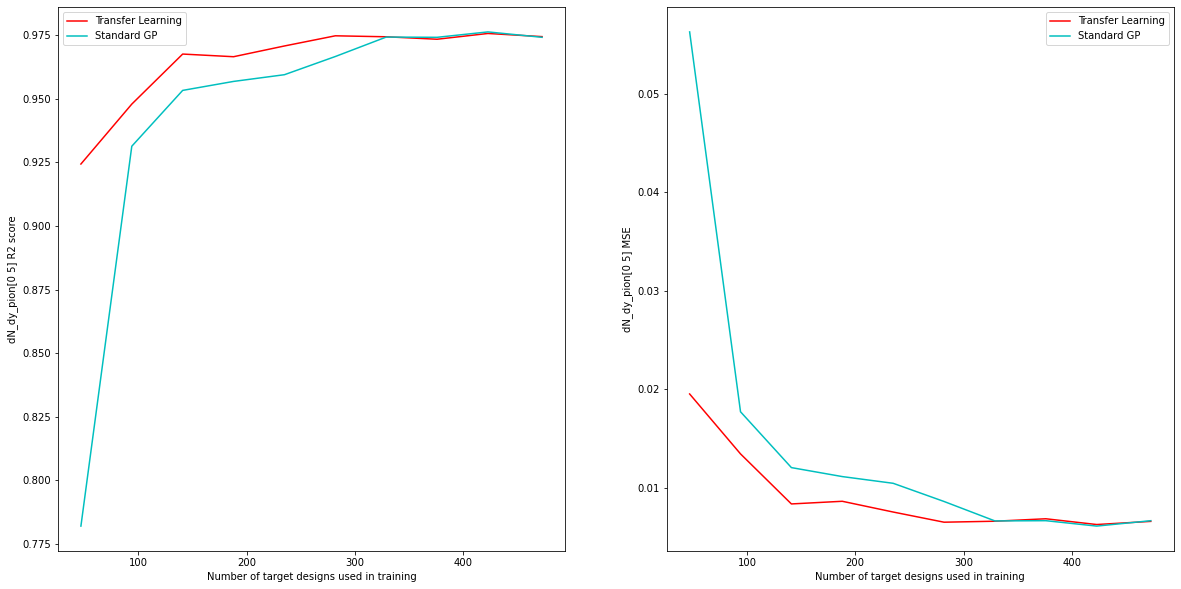

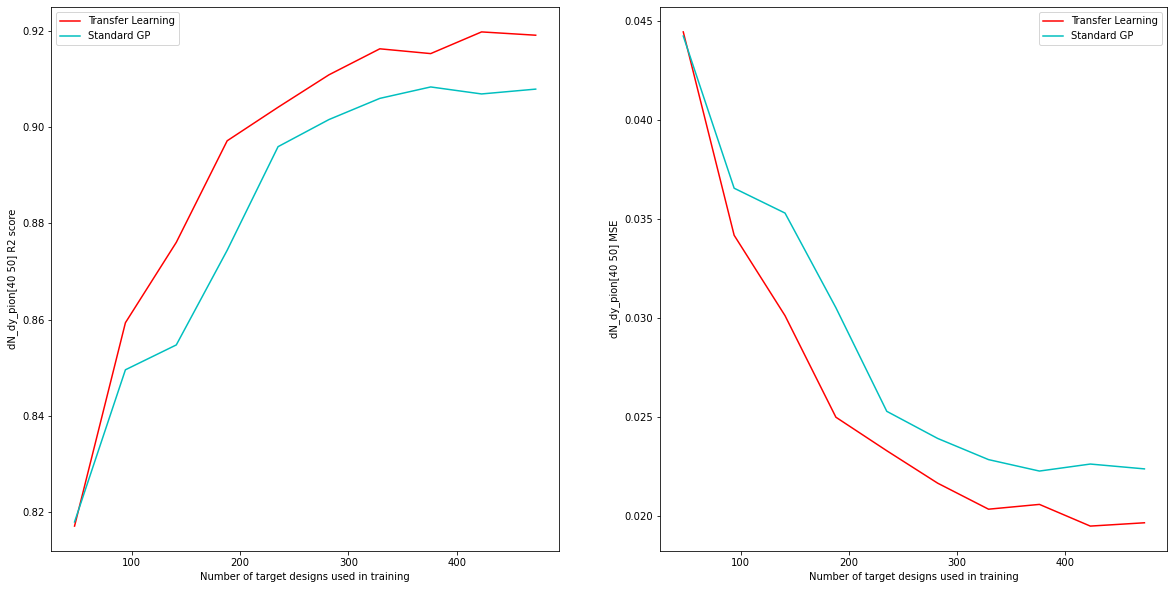

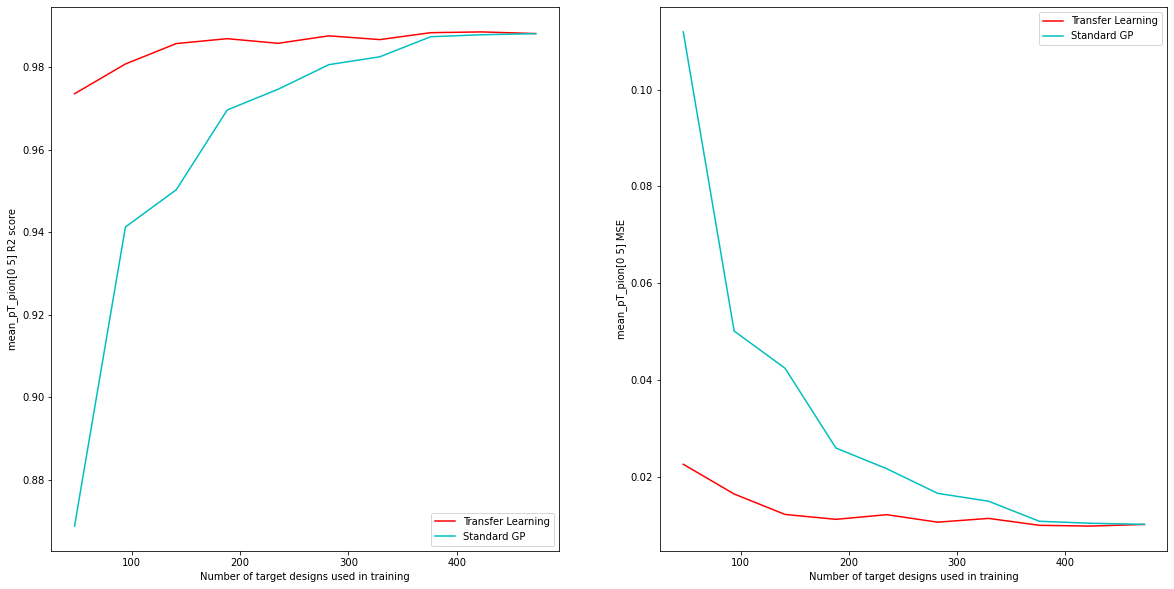

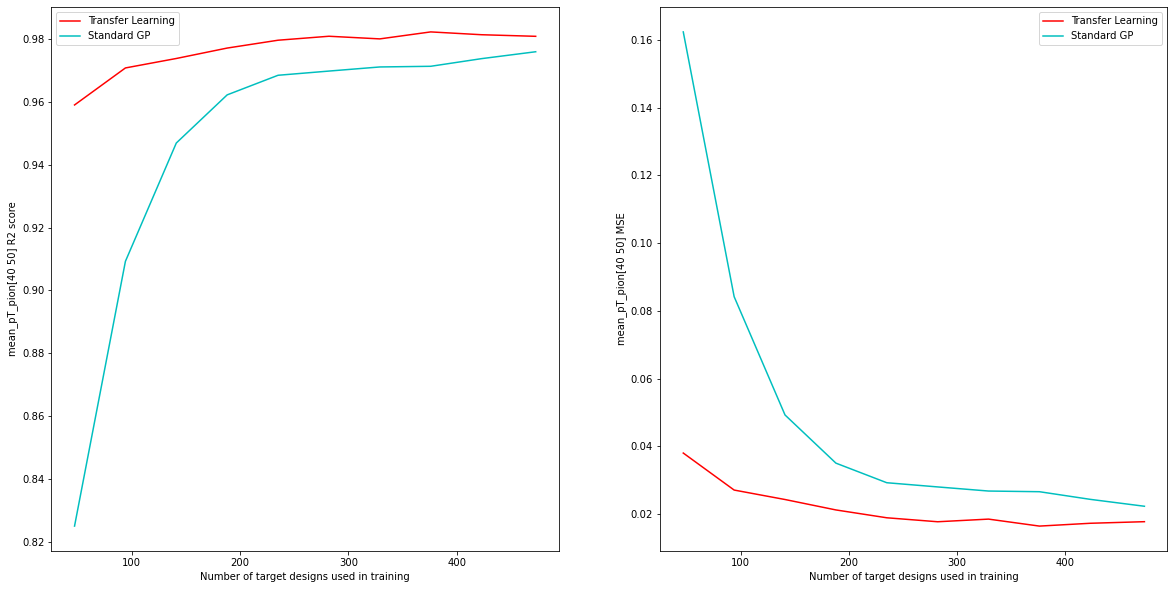

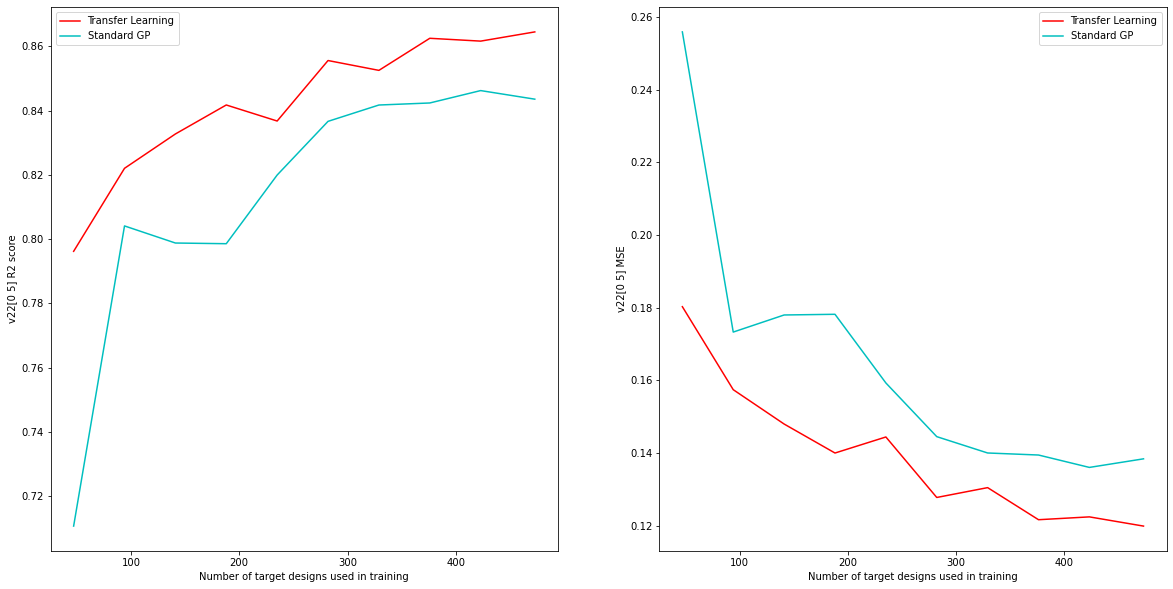

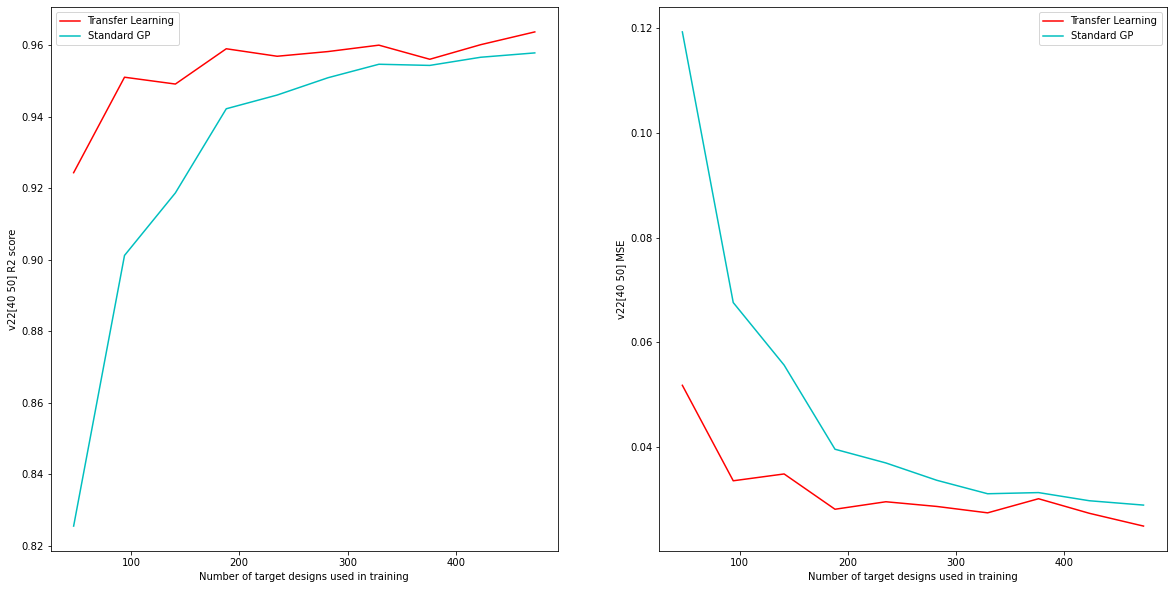

In [40]:
for obs in observables_choosen:
    fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1, ax2 = ax
    ax1.plot(plot_x_training,y_plot_obs('r2_lin_mf',obs), c ='r', label='Transfer Learning')
    ax1.plot(plot_x_training,y_plot_obs('r2_stand_GP',obs),c ='c', label='Standard GP')
    ax1.set_xlabel('Number of target designs used in training')
    ax1.set_ylabel(f'{obs} R2 score')
    ax1.legend()

    ax2.plot(plot_x_training,y_plot_obs('mse_lin_mf',obs), c ='r', label='Transfer Learning')
    ax2.plot(plot_x_training,y_plot_obs('mse_stand_GP',obs), c ='c', label='Standard GP')
    ax2.set_xlabel('Number of target designs used in training')
    ax2.set_ylabel(f'{obs} MSE')
    ax2.legend()
    #save_fig(f'{name}_ARD_PTB')